## Simple demonstration of KalmanFilter with Constant Velocity model in 2D

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
from bayesfilt.filters import KalmanFilter
from bayesfilt.models import ConstantVelocity, LinearObservationModel

In [21]:
# generate observations
np.random.seed(30)
dt_true = 0.1
nsamples = 100
tlist = np.linspace(0,nsamples*dt_true, nsamples)
xtrue = np.sin(0.4*tlist**1.1) 
ytrue = np.cos(0.4*tlist**1.3) 
xdata = xtrue + 0.05*np.random.randn(nsamples)
ydata = ytrue + 0.05*np.random.randn(nsamples)
odata = np.vstack([xdata, ydata]).T
len(odata)

100

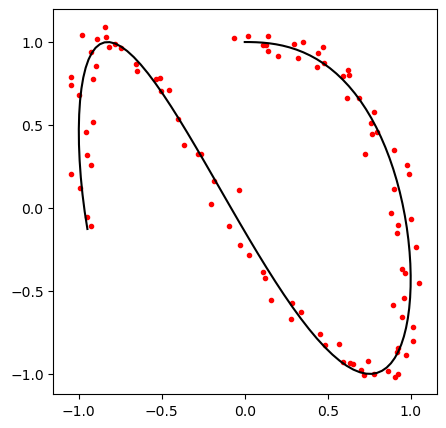

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(xdata, ydata, '.r')
ax.plot(xtrue, ytrue, '-k')
#ax.plot(tlist, ylist, '.r')
ax.set_aspect('equal')

In [23]:
# dynamics model
mm = ConstantVelocity(dof=2, sigma_speed=[0.2,0.2])
mm

ConstantVelocity(name='ConstantVelocity2D', nx=4, xnames=['Position0', 'Speed0', 'Position1', 'Speed1'])

In [24]:
# observation model
om = LinearObservationModel(nx=mm.nx, obs_state_inds=[0,2], xnames=mm.xnames)
om

LinearObservationModel(name='LinearObsModel(4/2)', nx=4, xnames=['Position0', 'Speed0', 'Position1', 'Speed1'])

In [25]:
# kalman filter
dt=0.05
kf = KalmanFilter(
    nx=mm.nx,
    ny=om.ny,
    dt=dt,
    mat_F=mm.func_Fmat(dt=dt),
    mat_H=om.Hmat,
    mat_Q=mm.func_Qmat(dt=dt),
    xnames=mm.xnames
)
kf

KalmanFilter: Setting dt_tol to 0.025


KalmanFilter(nx=4, ny=2, dt=0.05, dt_tol=0.025, object_id=0)

In [26]:
# initiate and run
kf.initiate(
    t0=tlist[0],
    m0=[odata[0][0],0., odata[0][1], 0.],
    P0=np.diag([0.1, 0.2, 0.1, 0.2]),
    flag='Update'
)
kf.filter(
    list_of_t=tlist[1:],
    list_of_y=odata[1:],
    list_of_R = np.diag([0.1**2, 0.1**2])
)
kf.smoother()
kf.df.head()

KalmanFilter(S): 100%|██████████| 201/201 [00:00<00:00, 499.00it/s]


,TimeElapsed,Flag,Position0,Position0_Var,Speed0,Speed0_Var,Position1,Position1_Var,Speed1,Speed1_Var,XresNorm,YresNorm,NIS,NEES,LogLik
0,0.00,Update,-0.063203,0.100000,0.000000,0.200000,1.022751,0.100000,0.000000,0.200000,NaN,NaN,NaN,NaN,NaN
1,0.05,Forecast,-0.063203,0.100502,0.000000,0.202000,1.022751,0.100502,0.000000,0.202000,NaN,NaN,NaN,NaN,NaN
2,0.10,Update,0.093186,0.009108,0.030967,0.200358,0.984542,0.009108,-0.007566,0.200358,0.164114,0.176770,0.278963,2.845480,0.211779
3,0.15,Forecast,0.094734,0.009791,0.030967,0.202358,0.984164,0.009791,-0.007566,0.202358,NaN,NaN,NaN,NaN,NaN
4,0.20,Update,0.055650,0.005347,-0.046999,0.181752,1.012792,0.005347,0.048092,0.181752,0.108022,0.093389,0.405918,0.466143,1.799525


In [27]:
kf.dfs.head()

,TimeElapsed,Flag,Position0,Position0_Var,Speed0,Speed0_Var,Position1,Position1_Var,Speed1,Speed1_Var,XresNorm,YresNorm,NIS,NEES,LogLik
0,0.00,Update,0.013146,0.003881,0.349809,0.021522,1.038303,0.003881,-0.085077,0.021522,NaN,NaN,NaN,NaN,NaN
1,0.05,Forecast,0.030724,0.003282,0.353269,0.019940,1.034028,0.003282,-0.085935,0.019940,NaN,NaN,NaN,NaN,NaN
2,0.10,Update,0.048472,0.002777,0.356653,0.018335,1.029709,0.002777,-0.086809,0.018335,0.060215,0.077445,0.303052,1.653420,1.933117
3,0.15,Forecast,0.066393,0.002358,0.360260,0.016754,1.025342,0.002358,-0.087943,0.016754,NaN,NaN,NaN,NaN,NaN
4,0.20,Update,0.084507,0.002016,0.364391,0.015241,1.020906,0.002016,-0.089582,0.015241,0.081229,0.066480,0.262623,1.664718,2.115488


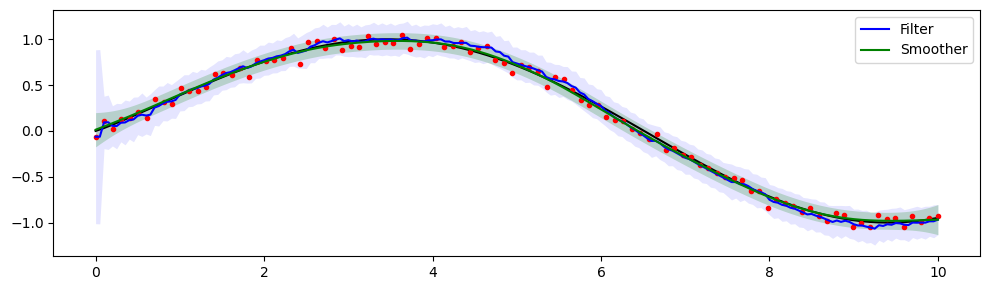

In [28]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(tlist, xtrue, '-k')
ax.plot(tlist, xdata, '.r')
# filter
idx = 0
ax.plot(kf.logger.time_elapsed, kf.logger.state_mean_i(idx), '-b', label='Filter')
ax.fill_between(
    kf.logger.time_elapsed, 
    kf.logger.state_mean_i(idx) - 3*np.sqrt(kf.logger.state_var_ij(idx)), 
    kf.logger.state_mean_i(idx) + 3*np.sqrt(kf.logger.state_var_ij(idx)),
    color='b', alpha=0.1, lw=0
)
# smoother
ax.plot(kf.slogger.time_elapsed, kf.slogger.state_mean_i(idx), '-g', label='Smoother')
ax.fill_between(
    kf.slogger.time_elapsed, 
    kf.slogger.state_mean_i(idx) - 3*np.sqrt(kf.slogger.state_var_ij(idx)), 
    kf.slogger.state_mean_i(idx) + 3*np.sqrt(kf.slogger.state_var_ij(idx)),
    color='g', alpha=0.2, lw=0
)
ax.legend()
fig.tight_layout()

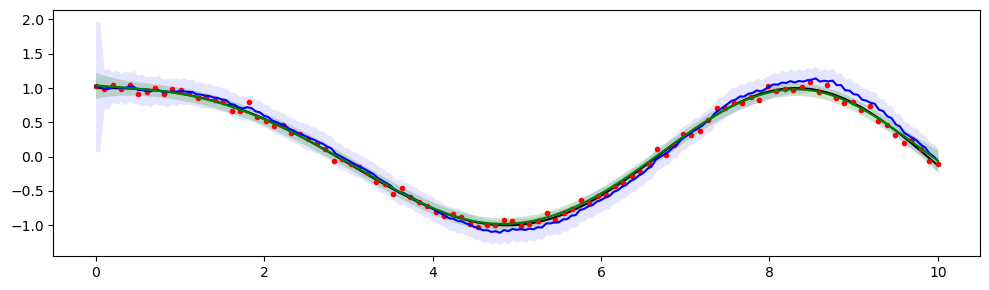

In [29]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(tlist, ytrue, '-k')
ax.plot(tlist, ydata, '.r')
# filter
idx = 2
ax.plot(kf.logger.time_elapsed, kf.logger.state_mean_i(idx), '-b')
ax.fill_between(
    kf.logger.time_elapsed, 
    kf.logger.state_mean_i(idx) - 3*np.sqrt(kf.logger.state_var_ij(idx)), 
    kf.logger.state_mean_i(idx) + 3*np.sqrt(kf.logger.state_var_ij(idx)),
    color='b', alpha=0.1, lw=0
)
# smoother
ax.plot(kf.slogger.time_elapsed, kf.slogger.state_mean_i(idx), '-g')
ax.fill_between(
    kf.slogger.time_elapsed, 
    kf.slogger.state_mean_i(idx) - 3*np.sqrt(kf.slogger.state_var_ij(idx)), 
    kf.slogger.state_mean_i(idx) + 3*np.sqrt(kf.slogger.state_var_ij(idx)),
    color='g', alpha=0.2, lw=0
)
fig.tight_layout()

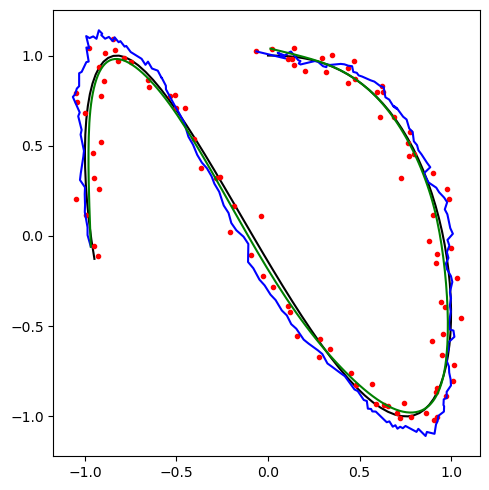

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(xtrue, ytrue, '-k')
ax.plot(xdata, ydata, '.r')
ax.plot(kf.logger.state_mean_i(0), kf.logger.state_mean_i(2), '-b')
ax.plot(kf.slogger.state_mean_i(0), kf.slogger.state_mean_i(2), '-g')
fig.tight_layout()

In [13]:
kf.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TimeElapsed    300 non-null    float64
 1   Flag           300 non-null    object 
 2   Position0      300 non-null    float64
 3   Position0_Var  300 non-null    float64
 4   Speed0         300 non-null    float64
 5   Speed0_Var     300 non-null    float64
 6   Position1      300 non-null    float64
 7   Position1_Var  300 non-null    float64
 8   Speed1         300 non-null    float64
 9   Speed1_Var     300 non-null    float64
 10  XresNorm       99 non-null     float64
 11  YresNorm       99 non-null     float64
 12  NIS            99 non-null     float64
 13  NEES           99 non-null     float64
 14  LogLik         99 non-null     float64
dtypes: float64(14), object(1)
memory usage: 35.3+ KB


In [14]:
kf.dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TimeElapsed    201 non-null    float64
 1   Flag           201 non-null    object 
 2   Position0      201 non-null    float64
 3   Position0_Var  201 non-null    float64
 4   Speed0         201 non-null    float64
 5   Speed0_Var     201 non-null    float64
 6   Position1      201 non-null    float64
 7   Position1_Var  201 non-null    float64
 8   Speed1         201 non-null    float64
 9   Speed1_Var     201 non-null    float64
 10  XresNorm       99 non-null     float64
 11  YresNorm       99 non-null     float64
 12  NIS            99 non-null     float64
 13  NEES           99 non-null     float64
 14  LogLik         99 non-null     float64
dtypes: float64(14), object(1)
memory usage: 23.7+ KB
